In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lxml

# Polish Presidential Election 2025 - Analysis (impossible to reproduce, the data from Wikipedia is not available anymore)

## Practice project using data available on Wikipedia

I want to get into the field of data analysis/data science and this is my very first data analysis practice project done from scratch.

### Which Wikipedia table is which?
This code iterates through every table on the page and previews it so we can look for the index of the table that is of interest to us.

In [2]:
url = "https://en.wikipedia.org/wiki/Opinion_polling_for_the_2025_Polish_presidential_election"
tables = pd.read_html(url, header=0)
print(f"Total tables: {len(tables)}")
#for i, table in enumerate(tables):
    #print(f"\nTable {i} preview:")
    #rint(table.head())

Total tables: 31


### Exploratory Data Analysis
Here we are going to process the main polling table consisting of every candidate and polls done by different organizations.

Create a DataFrame and handle column names:

In [3]:
polling_df = tables[2]
polling_df = polling_df.drop([0, 1]).reset_index(drop=True)
polling_df.rename(columns={"Polling firm/Link":"Pollster"}, inplace=True)

Here I am getting rid of irrelevant candidates with a lot of missing values and also the "Lead" column just so the project is simpler and clearer:

In [4]:
polling_df = polling_df.drop(columns=['Jakubiak WR', 'Stanowski ind.', 'Woch BS', 'Senyszyn SLD', 'Maciak RDiP', 'Bartoszewicz ind.', 'Others', 'Lead'])

Let's get rid of rows with sample size smaller than 1000 (we keep NaN values for the sake of keeping the important polls results):

In [5]:
polling_df['Sample size'] = polling_df['Sample size'].replace('–', np.nan)
polling_df['Sample size'] = pd.to_numeric(polling_df['Sample size'], errors='coerce')
polling_df = polling_df[(polling_df['Sample size'].isna()) | (polling_df['Sample size'] >= 1000)].reset_index(drop=True)

Let's import and clean the aggregated polls table done by Politico and ewybory to compare it with combined results of polls done in May from our table:

In [6]:
aggr_df = tables[0]
aggr_df = aggr_df.drop([0, 1]).reset_index(drop=True)
aggr_df = aggr_df.drop(columns=['Jakubiak WR', 'Stanowski ind.', 'Senyszyn SLD', 'Lead'])
aggr_df.rename(columns={"Others / don't know": "Don't know", "Last Update": "Fieldwork date", "Polling Aggregator/Link": "Pollster"}, inplace=True)
aggr_df.iloc[0, 9] = 4.1
aggr_df["Don't know"] = aggr_df["Don't know"].astype(float)

Define a function that will convert date ranges into the last day of the range:

In [7]:
def extract_last_date(date_str):
    if '–' in date_str:
        return date_str.split('–')[-1].strip()
    elif '-' in date_str:
        return date_str.split('-')[-1].strip()
    return date_str.strip()

Apply the function to the `Fieldwork date` columns and convert them to datetime format (so that plotting a Time Series is possible):

In [8]:
polling_df['Fieldwork date'] = polling_df['Fieldwork date'].apply(extract_last_date)
aggr_df['Fieldwork date'] = aggr_df['Fieldwork date'].apply(extract_last_date)
polling_df['Fieldwork date'] = pd.to_datetime(polling_df['Fieldwork date'], dayfirst=True, format='mixed')
aggr_df['Fieldwork date'] = pd.to_datetime(aggr_df['Fieldwork date'], dayfirst=True)

Create a new DataFrame containing actual first round results and drop the row containing results from polling_df (20/05/25)

In [9]:
results_df = polling_df.iloc[[0]]
polling_df = polling_df.drop([0]).reset_index(drop=True)

### Plots

Convert candidate columns in both datasets to numerical values so that it is possible to take the mean:

In [10]:
candidate_cols = [
    'Nawrocki PiS', 'Trzaskowski PO', 'Hołownia PL2050', 'Biejat NL',
    'Zandberg Razem', 'Mentzen Confederation', 'Braun KKP'
]
for col in candidate_cols:
    polling_df[col] = pd.to_numeric(polling_df[col], errors='coerce')
    aggr_df[col] = pd.to_numeric(aggr_df[col], errors='coerce')
    results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

Filter `polling_df` for polls conducted in May and aggregate by taking the mean:

In [11]:
polling_df_may = polling_df[polling_df['Fieldwork date'].dt.month == 5]
polling_df_may_mean = polling_df_may[candidate_cols].mean()

Take the mean of candidate columns in `aggr_df`:

In [12]:
aggr_df_mean = aggr_df[candidate_cols].mean()

Create a new DataFrame for easy side-by-side plotting:

In [13]:
comparison_df = pd.DataFrame({
    'Avg. of Individual May Polls (polling_df_may)': polling_df_may_mean,
    'Avg. of Aggregators (aggr_df)': aggr_df_mean
})

Plot a bar plot to see whether there is any significant difference in the mean of aggregators versus the mean of individual polls done in May:

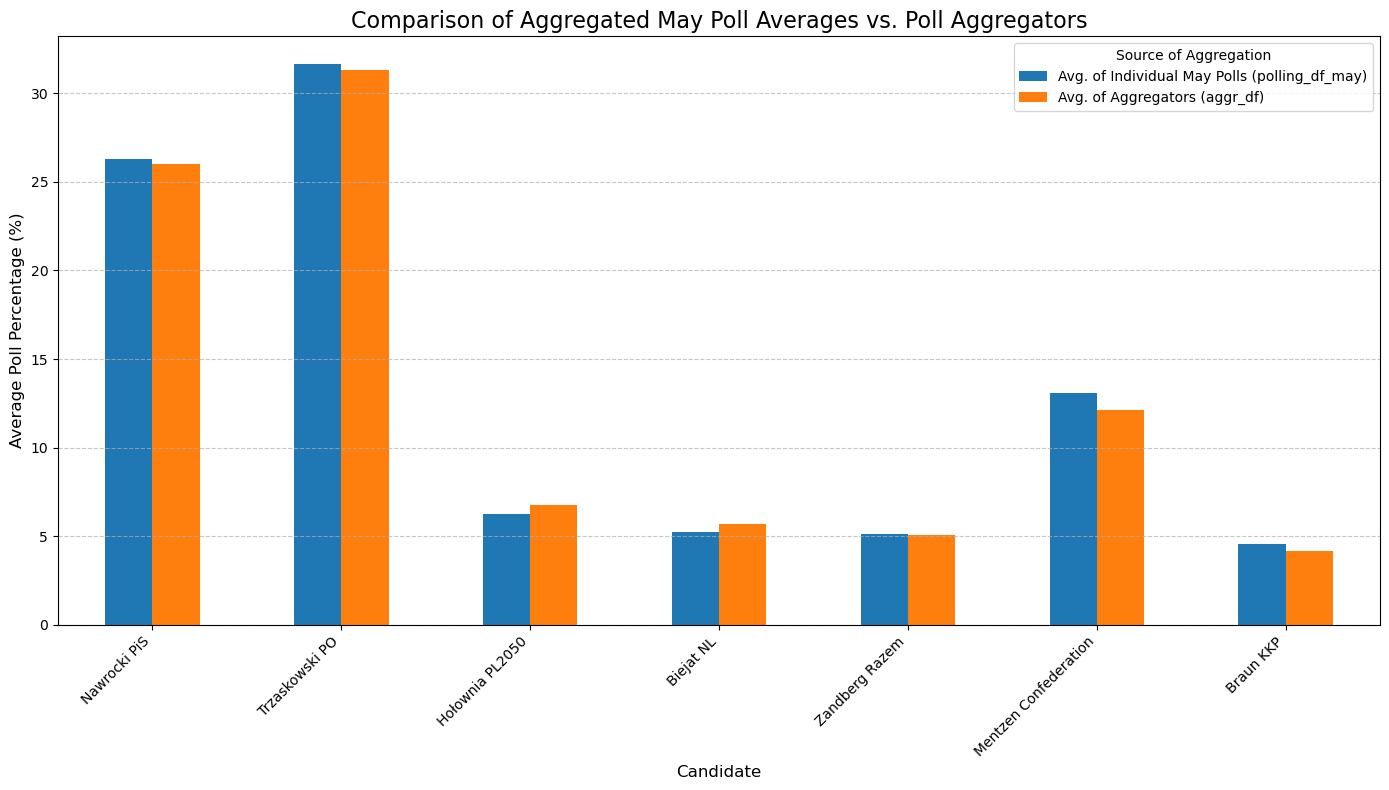

In [14]:
comparison_df.plot(kind='bar', figsize=(14,8))
plt.title('Comparison of Aggregated May Poll Averages vs. Poll Aggregators', fontsize=16)
plt.ylabel('Average Poll Percentage (%)', fontsize=12)
plt.xlabel('Candidate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Source of Aggregation')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### May average vs. Aggregators comparison conclusion

As we can see, poll aggregators estimate a way higher support for Nawrocki than his average support in individual May polls available on the Wikipedia page. Interestingly, at the same time, the aggregators underestimate the support for Hołownia, compared to the average of individual polls.

EDIT (15/05/25): Following the release of the latest polls, there is very little difference between the major candidates. It seems like the aggregators underestimate Trzaskowski, compared to individual polls.

EDIT (20/05/25): Knowing the actual results of the first round, we can certainly say that the aggregators (on average) severely underestimated the support of Nawrocki and Mentzen while overestimating Hołownia.

#### Actual first round results Bar Plot

First, process the `results_df`:

In [16]:
results_df_plot = results_df[candidate_cols]
results_series = results_df_plot.iloc[0]

Plot the Bar Plot:

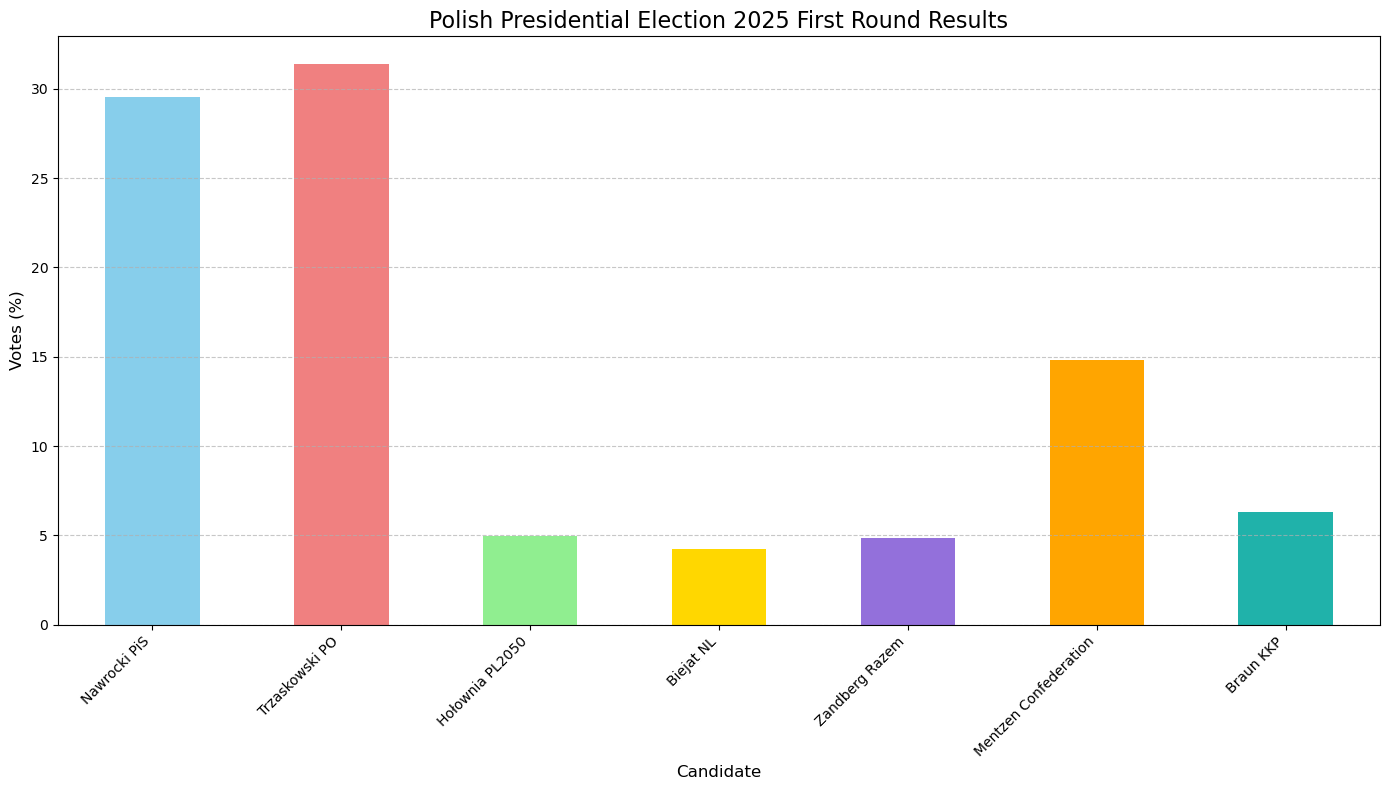

In [18]:
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'mediumpurple', 'orange', 'lightseagreen']
results_series.plot(kind='bar', figsize=(14,8), color=colors)
plt.title('Polish Presidential Election 2025 First Round Results', fontsize=16)
plt.ylabel('Votes (%)', fontsize=12)
plt.xlabel('Candidate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Mentzen** is strong, **Nawrocki** has way more support than initially expected, especially considering his *Jerzy Scandal*. **Trzaskowski**'s campaign team has to be sweating right now.

### Aggregators average vs. Actual results Comparison (Bar Plot)

First, let's create a new DataFrame combining `results_df` with `aggr_df`:

In [20]:
results_aggr_df = pd.DataFrame({
    'Actual First Round Results': results_series,
    'Avg. of Aggregators': aggr_df_mean
})

Plot the Bar Plot:

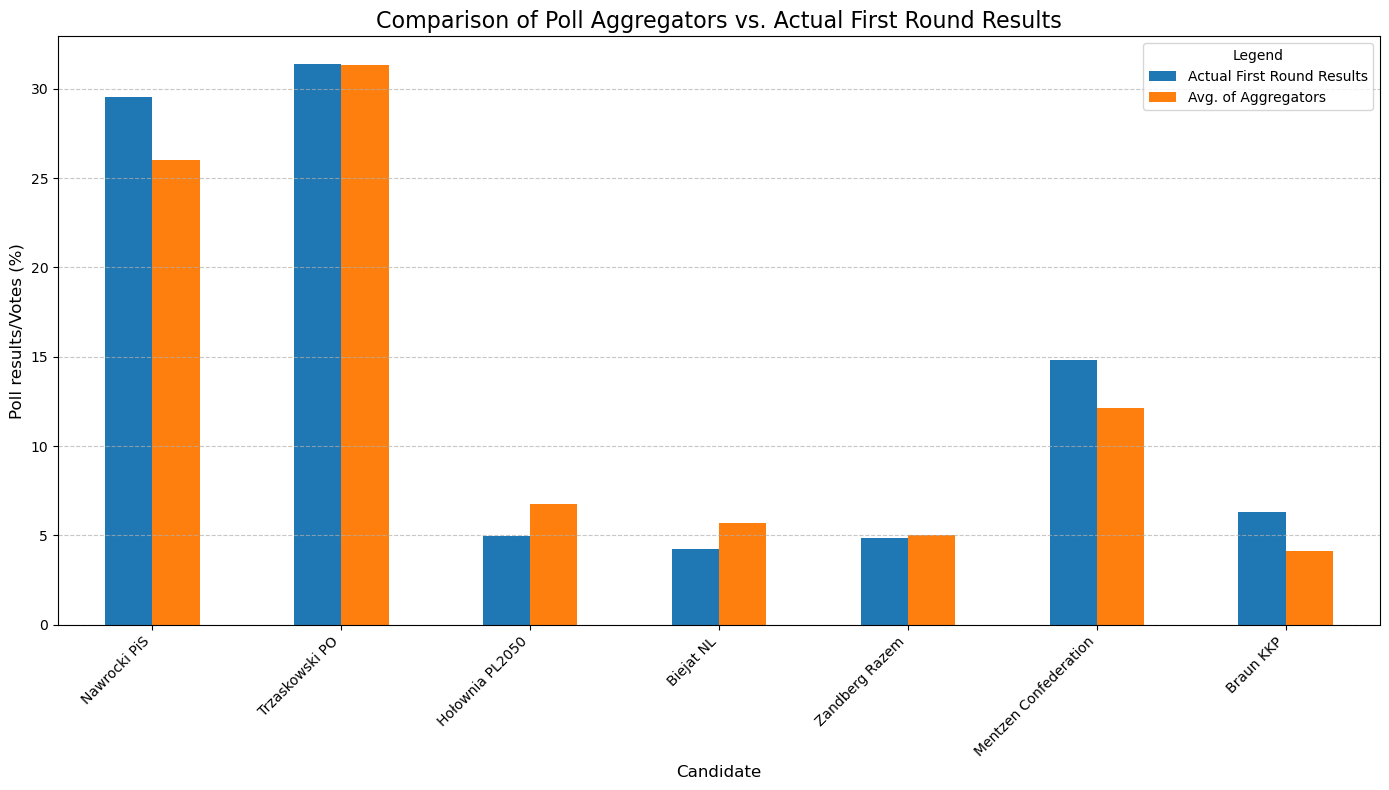

In [21]:
results_aggr_df.plot(kind='bar', figsize=(14,8))
plt.title('Comparison of Poll Aggregators vs. Actual First Round Results', fontsize=16)
plt.ylabel('Poll results/Votes (%)', fontsize=12)
plt.xlabel('Candidate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Legend')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Aggregators vs. Actual Results: Conclusion

We can make a significant number of interesting observations based on the above plot. First of all, a stunning difference between polls and the actual result of **Nawrocki**. On the other hand, the Aggregators were almost spot on when it comes to **Trzaskowski**'s support.

**Nawrocki**, **Mentzen**, and **Braun** were underestimated, while **Hołownia** and **Biejat** were overestimated, which is fascinating given the fact that the latter are current members of the government and the former form opposition. Coincidence? 

Looking at polls conducted on 16th May and also the Exit Polls, it seems like the pollster called **OGB** is surprisingly accurate. I will have to keep an eye on them.